# Experiments

In [158]:
#import python packages
import pandas as pd
import numpy as np
import torch
import scipy as sp
from scipy.spatial import distance

from sklearn.metrics import roc_auc_score, roc_curve, recall_score
from sklearn.preprocessing import normalize

from collections import OrderedDict, Counter

from reliability import *

import pickle


import matplotlib
# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42
# matplotlib.rcParams.update({'font.size': 16})

#load data
model_name = "textfooler"
task_name = "wnli"
victim = "bert_base"
msp_type = "multiply"

### ECE analysis

In [159]:
if victim == "bert_base":
    with open("./Threshold/"+str(task_name)+"_"+str(victim)+"_"+"msp.pickle", "rb") as input_file:
        msp_threshold = pickle.load(input_file)
elif task_name == "sst2":
    with open("./Threshold/"+str(task_name)+"_"+str(victim)+"_"+"msp_"+str(msp_type)+"_threshold99.pickle", "rb") as input_file:
        msp_threshold = pickle.load(input_file)
else:
    with open("./Threshold/"+str(task_name)+"_"+str(victim)+"_"+"msp_"+str(msp_type)+".pickle", "rb") as input_file:
        msp_threshold = pickle.load(input_file)

with open("./Threshold/"+str(task_name)+"_"+str(victim)+"_"+"md.pickle", "rb") as input_file:
    md_threshold = pickle.load(input_file)
    md_threshold = pd.DataFrame(md_threshold)

if victim == "bert_base":
    data = pd.read_csv('./data/'+str(task_name)+'/'+str(model_name)+'/log.csv',sep=',', index_col=False)
elif model_name == "peft":
    data = pd.read_csv('./data/results_peft_adv/'+str(task_name)+'/log_'+str(msp_type)+'.csv',sep=',', index_col=False)
else:
    data = pd.read_csv('./data/results_llama2_'+str(msp_type)+'/'+str(task_name)+'/llama2-7b'+'/'+str(model_name)+'/log.csv',sep=',', index_col=False)

data.columns

Index(['original_text', 'perturbed_text', 'original_score', 'perturbed_score',
       'original_output', 'perturbed_output', 'ground_truth_output',
       'num_queries', 'result_type'],
      dtype='object')

In [160]:
filter_index = (data["result_type"]=="Skipped")
# filter_index = (data["result_type"]=="Skipped")|(data["result_type"]=="Failed")
failed_index = []
for i in range(len(data)):
    if data['result_type'][i] == "Failed":
        failed_index.append(1)
    elif data['result_type'][i] != "Skipped":
        failed_index.append(0)
num_failed = (data["result_type"]=="Failed").sum()

print("original acc: ", 100*(1-filter_index.sum()/len(data)))
print("adv acc: ", 100*sum([data["perturbed_output"][i] == data["ground_truth_output"][i] for i in range(len(data))])/len(data))
print("ASR: ", 100*(data["result_type"]=="Successful").sum()/((data["result_type"]=="Successful").sum()+num_failed))

filter_index.sum(), num_failed, len(failed_index), len(data)

original acc:  56.33802816901409
adv acc:  4.225352112676056
ASR:  92.5


(31, 3, 40, 71)

In [161]:
def obtain_param(y, label, filter_index, tag='orig', file='csv'):
    # if tag=='orig':
    #     y_true = label
    # else:
    #     y_true = 1-label
    y_true = []
    y_pred = []
    y_conf = []

    for i in range(len(label)):
        if filter_index[i]:
            # print("?")
            # print(y.tolist()[i], label[i])
            continue
        if file=='csv':
            probs = y.tolist()[i]
            if probs != probs:
                continue
            else:
                if model_name != "peft":
                    # print(probs)
                    probs = probs[1:-1].strip().split(',')
                    probs = [float(x) for x in probs]
                    # new_probs = [probs[1-i] for i in range(len(probs))]
                    y_pred.append(probs.index(max(probs)))
                    y_conf.append(max(probs))
                    # y_conf.append(probs[label[i]])
                elif victim == 'llama':
                    # print(probs)
                    probs = probs[1:-1].strip().split(',')
                    probs = [float(x) for x in probs]
                    # new_probs = [probs[1-i] for i in range(len(probs))]
                    y_pred.append(probs.index(max(probs)))
                    y_conf.append(max(probs))
                    # y_conf.append(probs[label[i]])
                else:
                    y_pred.append(data.perturbed_output.tolist()[i])
                    y_conf.append(max(probs, 1-probs))
                    # print(probs)
                    # y_conf.append(probs)

                if tag=='orig':
                    if label[i] > 0.5:
                        y_true.append(1)
                    else:
                        y_true.append(0)
                elif tag=='adv':
                    if label[i] <= 0.5:
                        y_true.append(1)
                    else:
                        y_true.append(0)
        elif file=='pt':
            probs = y[i].tolist()
            if probs != probs:
                continue
            else:
                probs = [float(x) for x in probs]
                y_pred.append(probs.index(max(probs)))
                y_conf.append(max(probs))

                if tag=='orig':
                    if label[i] > 0.5:
                        y_true.append(1)
                    else:
                        y_true.append(0)
                elif tag=='adv':
                    if label[i] <= 0.5:
                        y_true.append(1)
                    else:
                        y_true.append(0)


    return np.array(y_true), np.array(y_pred), np.array(y_conf)



In [162]:
# obtain from csv
y_orig_true, y_orig_pred, y_orig_conf = obtain_param(data.original_score, data.ground_truth_output, filter_index)
# y_orig_true, y_orig_pred, y_orig_conf = obtain_param(data.y_orig, data.label)
print(len(y_orig_true), len(y_orig_pred))
print(y_orig_conf[:5], y_orig_pred[:5])

# # obtain from .pt
# probs = torch.load("./data/bertattack_mrpc/all_logits_original.pt")
# y_orig_true, y_orig_pred, y_orig_conf = obtain_param(probs, data.ground_truth_output, file='pt')

# title = "ECE analysis for original results"
# fig2 = reliability_diagram(y_orig_true, y_orig_pred, y_orig_conf, num_bins=10, 
#                           draw_ece=True,
#                           draw_bin_importance="alpha", 
#                           draw_averages=True,
#                           title="", figsize=(6, 6), dpi=100, 
#                           return_fig=True)

# fig2.savefig("./NAACL_figures/"+str(model_name)+"_"+str(task_name)+"_"+str(victim)+"_original_ece.pdf",  bbox_inches='tight')

40 40
[0.51529312 0.50871694 0.51178861 0.51187295 0.51007622] [0 0 0 0 0]


In [163]:
# obtain from csv
y_adv_true, y_adv_pred, y_adv_conf = obtain_param(data.perturbed_score, data.ground_truth_output, filter_index=filter_index, tag='adv')
# y_adv_true, y_adv_pred, y_adv_conf = obtain_param(data.y_adv, data.label, tag='adv')


# # obtain from .pt
# probs = torch.load("./data/bertattack_mrpc/all_logits_perturbed.pt")
# y_adv_true, y_adv_pred, y_adv_conf = obtain_param(probs, data.ground_truth_output, filter_index, tag='adv', file='pt')

# title = "ECE analysis for adversarial results"
# fig = reliability_diagram(y_adv_true, y_adv_pred, y_adv_conf, num_bins=10, 
#                           draw_ece=True,
#                           draw_bin_importance="alpha", 
#                           draw_averages=True,
#                           title="", figsize=(6, 6), dpi=100, 
#                           return_fig=True)
# fig.savefig("./NAACL_figures/"+str(model_name)+"_"+str(task_name)+"_"+str(victim)+"_adversarial_ece.pdf", bbox_inches='tight')

In [164]:
# # Plot the histograms
# # plt.figure(figsize=(15,12), dpi=200)
# ax = plt.axes()
# plt.grid(axis="y", alpha=0.5, linestyle='--', zorder=0)
# plt.hist([y_orig_conf, y_adv_conf], density=False, bins=20, alpha=0.8, zorder=10, color=['peru', 'slategrey'], label=['original', 'adversarial'])

# plt.legend(loc='upper right', ncol=2)
# plt.xlabel('Maximum Softmax Probability')
# plt.ylabel('Frequency')
# # plt.title('Distance to original data distribution of original and adversarial embeddings')
# # plt.savefig("./NAACL_figures/"+str(model_name)+"_"+str(task_name)+"_"+str(victim)+"_msp.pdf",  bbox_inches='tight')
# plt.show()

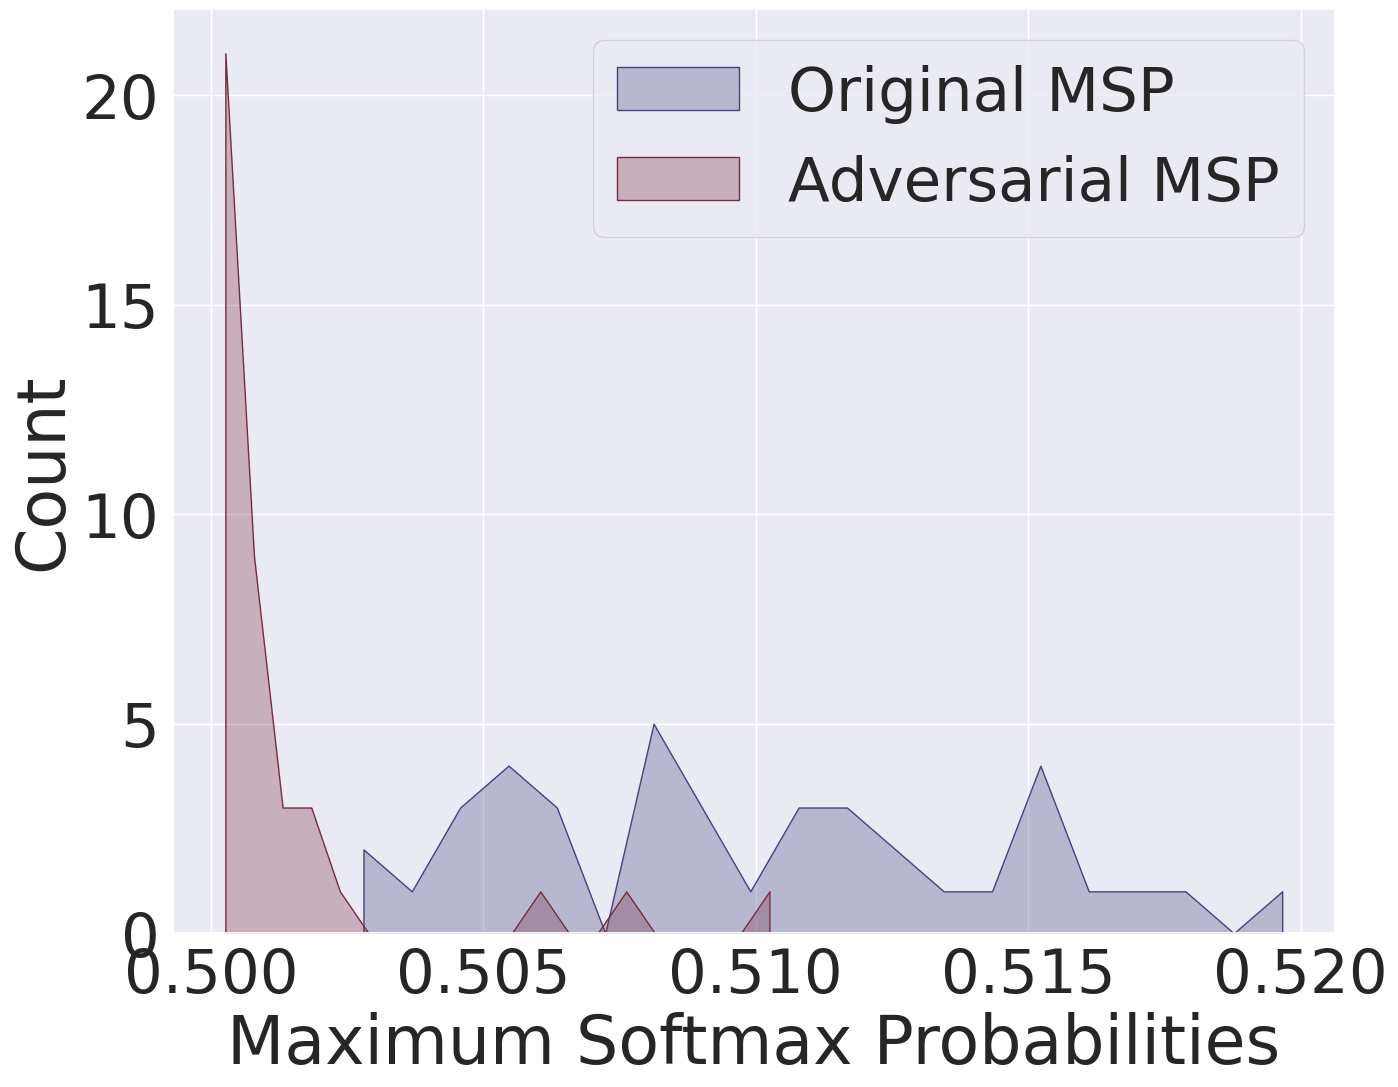

In [165]:
import seaborn as sns

new_y_orig_conf = []
new_y_adv_conf = []
for i in range(len(y_orig_conf)):
    # if not failed_index[i]:
        new_y_orig_conf.append(y_orig_conf[i])
        new_y_adv_conf.append(y_adv_conf[i])
len(y_orig_conf), len(new_y_orig_conf)

sns.set_style('whitegrid')
sns.set(rc={'figure.figsize': (15,12)})
sns.set(font_scale=4)
sns.set_palette("icefire", 2)
df_msp = pd.DataFrame(list(zip(new_y_orig_conf, new_y_adv_conf)), columns=['Original MSP', 'Adversarial MSP'])

ax1 = sns.histplot(data=df_msp['Original MSP'], element="poly", stat='count', bins=20, alpha=0.3)
ax1 = sns.histplot(data=df_msp['Adversarial MSP'], element="poly", stat='count', bins=20, alpha=0.3)
ax1.set(xlabel='Maximum Softmax Probabilities', ylabel='Count')
# ax1.set_ylim(0, 250)
# ax1.set_xlim(0.5, 1)
ax1.legend(['Original MSP', 'Adversarial MSP'])
# plt.savefig("./NAACL_figures/"+str(model_name)+"_"+str(task_name)+"_"+str(victim)+"_msp.pdf",  bbox_inches='tight')

### MSP OOD Detection

In [166]:
def compute_auroc(id_pps, ood_pps, normalize=False, return_curve=False):
    # Consider OOD data as positive examples, id_pps and ood_pps are negative MSPs
    y = np.concatenate((np.ones_like(ood_pps), np.zeros_like(id_pps)))
    scores = np.concatenate((ood_pps, id_pps))
    if normalize:
        scores = (scores - scores.min()) / (scores.max() - scores.min())
    if return_curve:
        return roc_curve(y, scores)
    else:
        return 100*roc_auc_score(y, scores)

def compute_far(id_pps, ood_pps, rate=5):
    # id_pps and ood_pps are negative MSPs
    #  measures the misclassification rate of ID examples at 95% OOD recall
    incorrect = len(id_pps[id_pps > np.percentile(ood_pps, rate)])
    return 100*incorrect / len(id_pps)

def compute_fpr(id_pps, ood_pps, rate=5, normalize=False):
    # id_pps and ood_pps are negative MSPs
    #  measures the FPR of ID examples at 95% OOD TPR
    y = np.concatenate((np.ones_like(ood_pps), np.zeros_like(id_pps)))
    scores = np.concatenate((ood_pps, id_pps))
    if normalize:
        scores = (scores - scores.min()) / (scores.max() - scores.min())
    fpr, tpr, thresh = roc_curve(y, scores)

    if all(tpr < 0.95):
        # No threshold allows TPR >= 0.95
        return 0
    elif all(tpr >= 0.95):
        # All thresholds allow TPR >= 0.95, so find lowest possible FPR
        idxs = [i for i, x in enumerate(tpr) if x >= 0.95]
        return min(map(lambda idx: fpr[idx], idxs))
    else:
        # Linear interp between values to get FPR (recall=FPR=FP/(FP+TN)) at TPR == 0.95 (precision=TPR=TP/(TP+FN))
        return 100*np.interp(0.95, tpr, fpr)


def compute_new_asr(num_failed, id_pps, ood_pps, normalize=False, tag='msp'):
    # obtain threshold
    if tag == 'msp':
        if victim == "llama" and task_name == "sst2":
            threshold = msp_threshold
        else:
            threshold_cal = -np.array(msp_threshold) # negative id msp ==> consider id as negative examples
            threshold = np.percentile(threshold_cal, 99) # false positive rate = 5%
    else:
        threshold_cal = md_threshold
        threshold = np.percentile(threshold_cal, 99) # false positive rate = 5%

    print("threshold: ", threshold)

    scores = np.concatenate((ood_pps, id_pps))
    print(max(scores), min(scores))
    if normalize:
        scores = (scores - scores.min()) / (scores.max() - scores.min())
    print(max(scores), min(scores))

    detected = 0
    non_detected = 0
    for i in range(len(ood_pps)):
        # print(scores[:len(ood_pps)][i])
        if scores[:len(ood_pps)][i] < threshold and not failed_index[i]:
            non_detected += 1
        elif scores[:len(ood_pps)][i] >= threshold and not failed_index[i]:
            detected += 1
    # detected = recall*len(ood_pps)
    # print(scores[:len(ood_pps)])
    # non_detected = len(ood_pps)-detected
    print(len(ood_pps), "num_failed: ", num_failed, "detected: ", detected, "non_detected:", non_detected)
    print(num_failed+detected+non_detected)
    print("detection rate: ", 100*detected/(detected+non_detected))

    print(len(ood_pps), num_failed, detected, non_detected)
    print(num_failed+detected+non_detected)

    return 100*non_detected/(num_failed+detected+non_detected)


# def compute_new_asr(num_failed, id_pps, ood_pps, normalize=False):
#     y = np.concatenate((np.ones_like(ood_pps), np.zeros_like(id_pps)))
#     scores = np.concatenate((ood_pps, id_pps))
#     if normalize:
#         scores = (scores - scores.min()) / (scores.max() - scores.min())
#     fpr, tpr, thresh = roc_curve(y, scores)

#     gaps = [tpr[i]-fpr[i] for i in range(len(tpr))]
#     max_gap = thresh[np.argmax(gaps)]
#     recall = tpr[np.argmax(gaps)]
#     print(max(thresh), min(thresh))
#     print(recall, max_gap, len(ood_pps), len(failed_index))

#     detected = 0
#     non_detected = 0
#     for i in range(len(ood_pps)):
#         if scores[:len(ood_pps)][i] < max_gap and not failed_index[i]:
#             non_detected += 1
#         elif scores[:len(ood_pps)][i] >= max_gap and not failed_index[i]:
#             detected += 1
#     # detected = recall*len(ood_pps)
#     # print(scores[:len(ood_pps)])
#     # non_detected = len(ood_pps)-detected
#     print(len(ood_pps), num_failed, detected, non_detected)
#     print(num_failed+detected+non_detected)
#     print(recall)

#     return 100*non_detected/(num_failed+detected+non_detected)



In [167]:
orig_adv_auroc = compute_auroc(-y_orig_conf, -y_adv_conf, normalize=True)
orig_adv_far = compute_far(-y_orig_conf, -y_adv_conf)
orig_adv_fpr = compute_fpr(-y_orig_conf, -y_adv_conf, rate=5, normalize=True)
orig_adv_new_asr = compute_new_asr(num_failed, -y_orig_conf, -y_adv_conf, normalize=False)

# print(y_adv_conf)
# print("orig_adv_far: ", orig_adv_far)
print("For original data and adversarial data:", "\n", "AUROC: ", orig_adv_auroc, "\n", "FPR: ", orig_adv_fpr, "\n", "New ASR: ", orig_adv_new_asr)

threshold:  -0.503668166399002
-0.5000050067901611 -0.5201026201248169
-0.5000050067901611 -0.5201026201248169
40 num_failed:  3 detected:  35 non_detected: 2
40
detection rate:  94.5945945945946
40 3 35 2
40
For original data and adversarial data: 
 AUROC:  97.0 
 FPR:  32.5 
 New ASR:  5.0


### MD analysis

In [168]:
orig_embed = []
adv_embed = []

# # load embeddings separate files
# for file in os.listdir("./data/models2/"):
#     arr = torch.load(os.path.join("./data/models2/", file))
#     arr_orig = list(arr[0])[0]
#     arr_adv = list(arr[1])[0]
#     # arr_orig = list(arr[0].mean(0))
#     # arr_adv = list(arr[1].mean(0))
#     orig_embed.append(arr_orig)
#     adv_embed.append(arr_adv)
# orig_embed = pd.DataFrame(orig_embed)
# adv_embed = pd.DataFrame(adv_embed)
# print(orig_embed)
# print(orig_embed.shape, adv_embed.shape)
# print(arr.shape)
# model_name='bertattack'

# load embeddings combined files
if victim == "bert_base":
    orig_data = torch.load("./data/"+str(task_name)+"/"+str(model_name)+"/all_last_hidden_states_original.pt")
    adv_data = torch.load("./data/"+str(task_name)+"/"+str(model_name)+"/all_last_hidden_states_perturbed.pt")
elif model_name == "peft":
    data = pd.read_csv('./data/results_peft_adv/'+str(task_name)+'/log_'+str(msp_type)+'.csv',sep=',', index_col=False)
    orig_data = torch.load("./data/results_peft_adv/"+str(task_name)+"/all_last_hidden_states_original.pt")
    adv_data = torch.load("./data/results_peft_adv/"+str(task_name)+"/all_last_hidden_states_perturbed.pt")
else:
    orig_data = torch.load("./data/results_llama2_"+str(msp_type)+"/"+str(task_name)+"/llama2-7b"+"/"+str(model_name)+"/all_last_hidden_states_original.pt")
    adv_data = torch.load("./data/results_llama2_"+str(msp_type)+"/"+str(task_name)+"/llama2-7b"+"/"+str(model_name)+"/all_last_hidden_states_perturbed.pt")
# orig_data = torch.load("./textattack/sst2/all_last_hidden_states_perturbed.pt")
# adv_data = torch.load("./textattack/"+str(task_name)+"/all_last_hidden_states_perturbed.pt")
print(task_name, len(orig_data), len(data))

for i in range(len(orig_data)):
    if filter_index[i]:
        continue
    if victim == "llama":
        arr_orig = list(orig_data[i])
        arr_adv = list(adv_data[i])
    else:
        arr_orig = list(orig_data[i])[0]
        arr_adv = list(adv_data[i])[0]
        # arr_orig = list(.mean(0))
        # arr_adv = list(.mean(0))
    orig_embed.append(arr_orig)
    adv_embed.append(arr_adv)
# print(arr_orig.shape)
# print(orig_data[i].shape)
orig_embed = pd.DataFrame(orig_embed)
adv_embed = pd.DataFrame(adv_embed)
# print(orig_embed)
print(orig_embed.shape, adv_embed.shape, md_threshold.shape)


wnli 71 71
(40, 768) (40, 768) (635, 768)


In [169]:
# def mahalanobis(x=None, data=None, cov=None):
#     """Compute the Mahalanobis Distance between each row of x and the data  
#     x    : vector or matrix of data with, say, p columns.
#     data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
#     cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
#     """
#     x_minus_mu = x - np.mean(data)
#     if not cov:
#         cov = np.cov(data.values.T)
#     inv_covmat = sp.linalg.inv(cov)
#     left_term = np.dot(x_minus_mu, inv_covmat)
#     mahal = np.dot(left_term, x_minus_mu.T)
#     return mahal.diagonal()

# def mahalanobis(u, cov, v):
#     delta = u-v
#     m = np.matmul(np.matmul(delta, cov), delta.T)
#     return torch.sqrt(m)[0]

# def _validate_vector(u, dtype=None):
#     u = np.asarray(u, dtype=dtype, order='c').squeeze()
#     # Ensure values such as u=1 and u=[1] still return 1-D arrays.
#     u = np.atleast_1d(u)
#     if u.ndim > 1:
#         raise ValueError("Input vector should be 1-D.")
#     return u

# def mahalanobis(u, v, VI):
#     u = _validate_vector(u)
#     v = _validate_vector(v)
#     VI = np.atleast_2d(VI)
#     delta = u - v
#     m = np.dot(np.dot(delta, VI), delta)
#     return np.sqrt(m)

def mahalanobis(u, v, VI):
    u = u.view(1, -1).double()  # Reshape u into a row vector
    v = v.view(1, -1).double()  # Reshape v into a row vector
    delta = u - v
    VI = VI.double()
    m = torch.matmul(torch.matmul(delta, VI), delta.t())
    return torch.sqrt(m)[0]

def my_normalize(x):
    max_num = max(x)
    min_num = min(x)

    result = []
    for num in x:
         result.append((max_num-num)/(max_num-min_num))
    return result

In [170]:
# Calculate the mean and covariance matrix of the in-distribution features
# print(orig_embed.shape)
# mean = np.array(np.mean(orig_embed, axis=0))
# cov = np.cov(orig_embed, rowvar=False)
with open('./MD/'+str(task_name).upper()+'_'+str(victim)+'_'+str(task_name)+'_mean.pickle', 'rb') as handle:
    mean = pickle.load(handle).detach().to('cpu')
with open('./MD/'+str(task_name).upper()+'_'+str(victim)+'_'+str(task_name)+'_cov.pickle', 'rb') as handle:
    cov = pickle.load(handle).detach().to('cpu')
print(mean.shape, cov.shape, type(mean))
# print(mean)

print(md_threshold.shape)
# threshold_mean = np.array(np.mean(md_threshold, axis=0))
# threshold_cov = np.cov(md_threshold, rowvar=False)
threshold_mean = mean
threshold_cov = cov
print(threshold_mean.shape, threshold_cov.shape, md_threshold.shape)

# Calculate the Mahalanobis distance for the in-distribution and OOD data
# orig_dist = distance.cdist(orig_embed, mean[np.newaxis, :], 'mahalanobis', VI=np.linalg.pinv(cov))
# adv_dist = distance.cdist(adv_embed, mean[np.newaxis, :], 'mahalanobis', VI=np.linalg.pinv(cov))
# threshold_dist = distance.cdist(md_threshold, threshold_mean[np.newaxis, :], 'mahalanobis', VI=np.linalg.pinv(threshold_cov))

# orig_dist = [mahalanobis(torch.tensor(orig_embed.values)[i, :], mean, torch.linalg.pinv(cov)) for i in range(len(orig_embed))]
# adv_dist = [mahalanobis(torch.tensor(adv_embed.values)[i, :], mean, torch.linalg.pinv(cov)) for i in range(len(adv_embed))]
# threshold_dist = [mahalanobis(torch.tensor(md_threshold.values)[i,:], threshold_mean, torch.linalg.pinv(threshold_cov)) for i in range(len(md_threshold))]

print(type(mean), type(cov))
print(type(orig_embed), type(md_threshold))
vi = torch.linalg.pinv(cov)
orig_dist = distance.cdist(torch.tensor(orig_embed.values), mean, 'mahalanobis', VI=vi)
adv_dist = distance.cdist(torch.tensor(adv_embed.values), mean, 'mahalanobis', VI=vi)
threshold_dist = distance.cdist(torch.tensor(md_threshold.values), threshold_mean, 'mahalanobis', VI=vi)
print("np.linalg.pinv(threshold_cov): ", np.abs(threshold_cov).min())
# print(adv_embed.mean(axis=0).shape, np.min(np.abs(np.linalg.pinv(cov))), np.max(np.abs(np.linalg.pinv(cov))))
print(np.abs(cov).min())
print(len(orig_dist), len(adv_dist), len(threshold_dist))
# print(orig_embed[1], orig_dist[1])

# dist = np.append(orig_dist, adv_dist).reshape(-1, 1)
# new_dist = []
# for num in dist:
#     new_dist.append(num[0])

# orig_dist = list(new_dist[:len(orig_dist)])
# adv_dist = list(new_dist[len(orig_dist):])
orig_dist = [num[0] for num in orig_dist]
adv_dist = [num[0] for num in adv_dist]
threshold_dist = [num[0] for num in threshold_dist]

# # # print(new_dist)
# # print(len(new_dist))
# # print(len(orig_dist), len(adv_dist))
# print(max(orig_dist), min(orig_dist))
# print(max(adv_dist), min(adv_dist))
# print(max(threshold_dist), min(threshold_dist))

torch.Size([1, 768]) torch.Size([768, 768]) <class 'torch.Tensor'>
(635, 768)
torch.Size([1, 768]) torch.Size([768, 768]) (635, 768)
<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
np.linalg.pinv(threshold_cov):  tensor(3.1260e-08)
tensor(3.1260e-08)
40 40 635


In [171]:
# # Plot the histograms
# # plt.figure(figsize=(15,12), dpi=200)
# ax = plt.axes()
# plt.grid(axis="y", alpha=0.5, linestyle='--', zorder=0)
# plt.hist([orig_dist, adv_dist], density=False, bins=20, alpha=0.8, zorder=10, color=['peru', 'slategrey'], label=['original', 'adversarial'])

# plt.legend(loc='upper right', ncol=2)
# plt.xlabel('Mahalanobis Distance')
# plt.ylabel('Frequency')
# # plt.title('Distance to original data distribution of original and adversarial embeddings')
# # plt.savefig("./NAACL_figures/"+str(model_name)+"_"+str(task_name)+"_"+str(victim)+"_distribution.pdf",  bbox_inches='tight')
# plt.show()

In [172]:
import seaborn as sns
import random

new_orig_dist = []
new_adv_dist = []
for i in range(len(orig_dist)):
    # if not failed_index[i]:
        new_orig_dist.append(orig_dist[i])
        new_adv_dist.append(adv_dist[i])
len(orig_dist), len(new_orig_dist)

(40, 40)

24.342450425118194 40


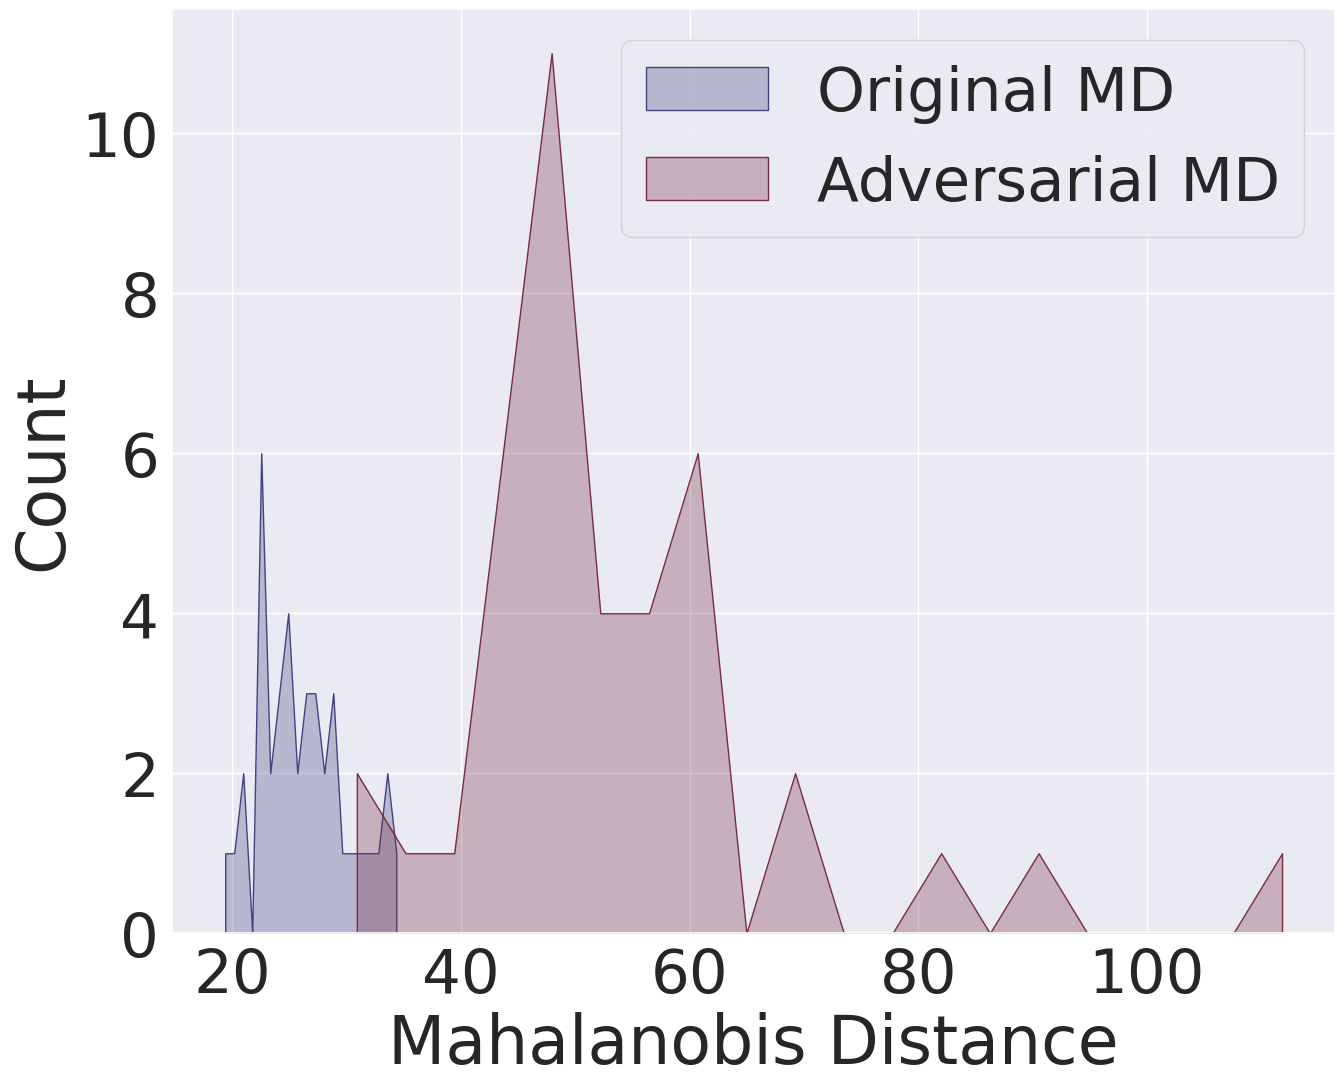

In [173]:
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize': (15,12)})
sns.set(font_scale=4)
sns.set_palette("icefire", 2)
df_md = pd.DataFrame(list(zip(new_orig_dist, new_adv_dist)), columns=['Original MD', 'Adversarial MD'])

threshold = np.percentile(threshold_dist, 99)
print(threshold, (new_adv_dist>threshold).sum())
ax1 = sns.histplot(data=df_md['Original MD'], element="poly", stat='count', bins=20, alpha=0.3)
ax1 = sns.histplot(data=df_md['Adversarial MD'], element="poly", stat='count', bins=20, alpha=0.3)

ax1.set(xlabel='Mahalanobis Distance', ylabel='Count')
# ax1.set_ylim(0, 60)
# ax1.set_xlim(0, 50)
ax1.legend(['Original MD', 'Adversarial MD'])
# plt.savefig("./NAACL_figures/"+str(model_name)+"_"+str(task_name)+"_"+str(victim)+"_md.pdf",  bbox_inches='tight')

### MD detection

In [174]:
def compute_auroc(id_pps, ood_pps, normalize=False, return_curve=False):
    # Consider OOD data as positive examples, id_pps and ood_pps are negative MSPs
    y = np.concatenate((np.ones_like(ood_pps), np.zeros_like(id_pps)))
    scores = np.concatenate((ood_pps, id_pps))
    if normalize:
        scores = (scores - scores.min()) / (scores.max() - scores.min())
    if return_curve:
        return roc_curve(y, scores)
    else:
        return 100*roc_auc_score(y, scores)

def compute_far(id_pps, ood_pps, rate=5):
    # id_pps and ood_pps are negative MSPs
    #  measures the misclassification rate of ID examples at 95% OOD recall
    incorrect = len(id_pps[id_pps > np.percentile(ood_pps, rate)])
    return 100*incorrect / len(id_pps)


def compute_new_asr(num_failed, id_pps, ood_pps, normalize=False, tag='msp'):
    # obtain threshold
    if tag == 'msp':
        threshold_cal = -np.array(msp_threshold) # negative id msp ==> consider id as negative examples
    else:
        print("md")
        threshold_cal = threshold_dist # id md ==> consider id as negative examples
    # print(threshold_cal)
    threshold = np.percentile(threshold_cal, 99) # false positive rate = 5%
    print("threshold: ", threshold)
    print("threshold max, min, mean", max(threshold_dist), min(threshold_dist), np.array(threshold_dist).mean())

    scores = np.concatenate((ood_pps, id_pps))
    print("ood max, min, mean: ", max(ood_pps), min(ood_pps), ood_pps.mean())
    if normalize:
        scores = (scores - scores.min()) / (scores.max() - scores.min())
    print("id max, min, mean: ", max(id_pps), min(id_pps), id_pps.mean())

    detected = 0
    non_detected = 0
    non_detect_fail = 0
    detect_fail = 0
    for i in range(len(ood_pps)):
        # print(scores[:len(ood_pps)][i])
        if scores[:len(ood_pps)][i] <= threshold and not failed_index[i]:
            non_detected += 1
        elif scores[:len(ood_pps)][i] > threshold and not failed_index[i]:
            detected += 1
        elif scores[:len(ood_pps)][i] <= threshold and failed_index[i]:
            non_detect_fail += 1
        elif scores[:len(ood_pps)][i] > threshold and failed_index[i]:
            detect_fail += 1
            # print(scores[:len(ood_pps)][i])
    print(len(ood_pps), "num_failed: ", num_failed, non_detect_fail, detect_fail, "detected: ", detected, "non_detected:", non_detected)
    print(num_failed+detected+non_detected)
    print("detection rate: ", 100*detected/(detected+non_detected))

    return 100*non_detected/(num_failed+detected+non_detected)

In [175]:
threshold = np.percentile(orig_dist, 95)
print(min(orig_dist), max(orig_dist))
print(orig_dist)
print(threshold)

id_pps = []
ood_pps = []
for i in range(len(orig_dist)):
    orig = orig_dist[i]
    adv = adv_dist[i]
    if orig<=threshold:
        id_pps.append(0) # id: negative (id) ==> True Negative
    else:
        id_pps.append(1) # id: positive ==> False Positive
    if adv<=threshold:
        ood_pps.append(0) # ood: negative (id) ==> False Negative
    else:
        ood_pps.append(1) # ood: positive ==> True Positive
id_pps = np.array(id_pps)
ood_pps = np.array(ood_pps)


# from scipy.special import softmax

# id_pps = softmax(orig_dist)
# ood_pps = softmax(adv_dist)

18.9804451403957 34.73489460926477
[33.580295672873376, 31.76612342957325, 23.314163157126174, 23.544551095769393, 24.529969340020127, 27.913364636328524, 34.73489460926477, 22.523910609627077, 27.281023201602554, 25.53071970554664, 21.33459965509937, 30.22029782008677, 22.40961786867824, 18.9804451403957, 23.75155010330654, 27.307870892465427, 22.761309294937508, 26.157419765610452, 25.850764653588566, 24.62830411475427, 20.570341009657636, 29.726325310074316, 33.235019662130284, 29.195596447694953, 24.802651269750847, 23.810507720995314, 22.690699737708357, 24.387385098451578, 31.036572926567686, 22.478850401802628, 24.64434577805806, 19.92881665120945, 26.547734911769506, 32.471022333149115, 26.50758606785531, 27.085142175037493, 22.41573283167497, 28.65892501508727, 27.896519539083837, 28.648101631830453]
33.252283462667435


In [176]:
# orig_adv_auroc = compute_auroc(id_pps, ood_pps, normalize=True)
# orig_adv_far = compute_far(id_pps, ood_pps)
# print("For original data and adversarial data:", "\n", "AUROC: ", orig_adv_auroc, "\n", "FAR: ", orig_adv_far)

orig_adv_auroc = compute_auroc(id_pps, ood_pps, normalize=True)
# orig_adv_far = compute_far(id_pps, ood_pps)
orig_adv_fpr = compute_fpr(id_pps, ood_pps, rate=5, normalize=True)
orig_adv_new_asr = compute_new_asr(num_failed, np.array(orig_dist), np.array(adv_dist), normalize=False, tag='md')

print(orig_adv_far)
print("For original data and adversarial data:", "\n", "AUROC: ", orig_adv_auroc, "\n", "FPR: ", orig_adv_fpr, "\n", "New ASR: ", orig_adv_new_asr)

md
threshold:  24.342450425118194
threshold max, min, mean 24.849802640940847 12.119022071748947 19.397530227920555
ood max, min, mean:  113.95326505450993 28.759069853710162 53.685851234882875
id max, min, mean:  34.73489460926477 18.9804451403957 26.121476782156094
40 num_failed:  3 0 3 detected:  37 non_detected: 0
40
detection rate:  100.0
27.5
For original data and adversarial data: 
 AUROC:  95.0 
 FPR:  5.0 
 New ASR:  0.0


## draft


In [177]:
# #489.338681732387 23.07957848132203
# #462.940315762595 23.079573621697765
# md
# threshold:  31.960401054181116
# 54.568800101341544 7.538723236953926
# ood max, min, mean:  42.977610610944645 10.883595564543477 26.537591320410606
# id max, min, mean:  44.54491063200255 7.996370771660133 19.88331324440851
# 806 num_failed:  172 125 47 detected:  94 non_detected: 540
# 806
# detection rate:  14.826498422712934
# 45.28535980148883
# For original data and adversarial data: 
#  AUROC:  55.08684863523574 
#  FPR:  94.39970717423132 
#  New ASR:  66.99751861042184

# md
# threshold:  38.75654966912077
# 50.132696321622085 10.520591564499972
# ood max, min, mean:  60.86474771976054 20.471762082320293 36.82345458393007
# id max, min, mean:  76.01520366582015 10.518776479736388 32.192795713030236
# 358 num_failed:  41 39 2 detected:  134 non_detected: 183
# 358
# detection rate:  42.27129337539432
# 26.536312849162012
# For original data and adversarial data: 
#  AUROC:  49.30167597765364 
#  FPR:  95.07246376811594 
#  New ASR:  51.11731843575419

In [178]:
# # obtain llama MD and threshold
# for task in ['cola', 'rte', 'mrpc', 'sst2']:
#     # md = torch.load("./llama_train/results_llama2_train_4more_3/"+str(task)+"/all_last_hidden_state.pt")
#     msp_m = torch.load("./llama_train/results_llama2_train_4more_3/"+str(task)+"/all_logits_multiply.pt")
#     # msp_s = torch.load("./llama_train/results_llama2_train_4more_0/"+str(task)+"/all_logits_single.pt")
#     # md = torch.tensor(md)
#     # msp_s = torch.tensor(msp_s)
#     msp_m = torch.tensor(msp_m)

#     # threshold
#     msp_m = [max(value) for value in msp_m]
#     # msp_s = [max(value) for value in msp_s]
#     # md_thres = [value.tolist() for value in md]

#     # # print(md_thres[0])
#     if task == "sst2":
#         msp_m = -np.array(msp_m) # negative id msp ==> consider id as negative examples
#         msp_m = np.percentile(msp_m, 99) # false positive rate = 5%
#     with open('./Threshold/'+str(task)+'_llama_msp_multiply_3.pickle', 'wb') as handle:
#         pickle.dump(msp_m, handle, protocol=pickle.HIGHEST_PROTOCOL)
#     # with open('./Threshold/'+str(task)+'_llama_msp_single.pickle', 'wb') as handle:
#     #     pickle.dump(msp_s, handle, protocol=pickle.HIGHEST_PROTOCOL)
#     # with open('./Threshold/'+str(task)+'_llama_md_3.pickle', 'wb') as handle:
#     #     pickle.dump(md_thres, handle, protocol=pickle.HIGHEST_PROTOCOL)

#     # # md
#     # md_mean = torch.mean(md, axis=0).reshape(1, -1).to('cuda')
#     # md_cov = torch.cov(md.T).to('cuda')
#     # with open('./MD/'+str(task).upper()+'_llama_'+str(task)+'_mean_3.pickle', 'wb') as handle:
#     #     pickle.dump(md_mean, handle, protocol=pickle.HIGHEST_PROTOCOL)
#     # with open('./MD/'+str(task).upper()+'_llama_'+str(task)+'_cov_3.pickle', 'wb') as handle:
#     #     pickle.dump(md_cov, handle, protocol=pickle.HIGHEST_PROTOCOL)

#     # break
    

In [179]:
# from scipy.spatial import distance
# # obtain llama MD and threshold
# for llama_num in [0, 1, 2, 3]:
#     for task in ['cola', 'rte', 'mrpc', 'sst2']:
#         md = torch.load("./llama_train/results_llama2_train_4more_"+str(llama_num)+"/"+str(task)+"/all_last_hidden_state.pt")
#         md = torch.tensor(md)
#         md_thres = [value.tolist() for value in md]

#         md_mean = torch.mean(md, axis=0).reshape(1, -1).to('cuda').detach().to('cpu')
#         md_cov = torch.cov(md.T).to('cuda').detach().to('cpu')

#         orig_data = torch.load("./data/llama2_multiply/results_llama2_multiply"+'_'+str(llama_num)+"/"+str(task)+"/llama2-7b"+"/bertattack"+"/all_last_hidden_states_original.pt")
#         data = pd.read_csv('./data/llama2_multiply/results_llama2_multiply'+'_'+str(llama_num)+'/'+str(task)+'/llama2-7b'+'/bertattack/log.csv',sep=',', index_col=False)
#         filter_index = (data["result_type"]=="Skipped")
#         orig_embed = []
#         for i in range(len(orig_data)):
#             if filter_index[i]:
#                 continue
#             if victim == "llama":
#                 arr_orig = list(orig_data[i])
#             else:
#                 arr_orig = list(orig_data[i])[0]
#             orig_embed.append(arr_orig)
#         orig_embed = pd.DataFrame(orig_embed)
#         vi = torch.linalg.pinv(md_cov)
#         orig_dist = distance.cdist(torch.tensor(orig_embed.values), md_mean, 'mahalanobis', VI=vi)
#         threshold_dist = distance.cdist(torch.tensor(md_thres.values), md_mean, 'mahalanobis', VI=vi)

#         break
#     break

    

In [180]:

# with open("./sst2_train_loss.pickle", "rb") as input_file:
#     mrpc_train_loss = pickle.load(input_file)
# # print(mrpc_train_loss)
# train_msp = [float(values[0].detach().to('cpu').numpy()) for values in mrpc_train_loss]
# train_md = [float(values[1][0].detach().to('cpu').numpy()) for values in mrpc_train_loss]
# train_loss = [values[0].detach().to('cpu').numpy() + values[1][0].detach().to('cpu').numpy() for values in mrpc_train_loss]

# mrpc_train_loss = [[train_msp[i]-train_msp[0], train_md[i]-train_md[0], train_loss[i]-train_loss[0]] for i in range(0, len(train_loss), 100)]
# index = list(range(0, len(train_loss), 100))

# mrpc_train_loss[:3]

In [181]:
# import seaborn as sns
# import random

# sns.set_style('whitegrid')
# sns.set(rc={'figure.figsize': (15,12)})
# sns.set_palette("icefire")
# sns.set(font_scale=3)
# df_mrpc = pd.DataFrame(mrpc_train_loss, index, columns=["MSP Loss", "MD Loss", "DAL Loss"])
# # df_mrpc
# ax1 = sns.lineplot(data=df_mrpc, palette="rocket", dashes=False)
# sns.move_legend(ax1, "upper right")
# ax1.set(xlabel='Steps', ylabel='\u0394 Loss')
# plt.savefig("./NAACL_figures/loss.pdf",  bbox_inches='tight')

In [182]:

# with open("./mrpc_val_loss.pickle", "rb") as input_file:
#     mrpc_val_loss = pickle.load(input_file)